# Final Version of Phydra GEKKO Core v1
this is the very basis of core processes that was used for the first published version

can be used to develop the framework further in a smaller test environment, in these early versions

# TODO:
X 1. add value storage, both in Env and Comp
X 2. add a simple flux
# 3. test dim init: within Comp 1D (, within Env, flexible)

#IDEA:

#remove the ENVS for noW! none of my use cases actually employ it!
#so it would be awkward to present it there like that!!!

instead, just basic 0D model, but clean interface should be the goal!

in effect, as long as I use m.Array instead of m.SV, I should be able to add any kind of dims later on!

In [2]:
from gekko import GEKKO
import xsimlab as xs
import numpy as np

# to create dynamic storage of fluxes
from collections import defaultdict

# to measure process time
import time as tm

In [3]:
# a function to randomly generate simple string as label for 
    # xsimlab dimension that should be flexible (scalar or list)
    
import string
import random

def id_generator(size=6, chars=string.ascii_uppercase + string.digits):
    return ''.join(random.choice(chars) for _ in range(size))

In [151]:
@xs.process
class GekkoCore:
    m = xs.any_object()
    
    def initialize(self):
        print('initializing model core')
        self.m = GEKKO(remote=False, name='phydra')
        
        # add defaultdict of list that dynamically stores fluxes by component label
        self.m.phydra_fluxes = defaultdict(list)
        # same for state variables
        self.m.phydra_SVs = defaultdict()
        # same for forcings
        self.m.phydra_forcings = defaultdict()
        
    def finalize(self):
        print('finalizing gekko core: cleanup')
        self.m.open_folder()
        #self.m.cleanup()

        
@xs.process
class GekkoContext:
    """ Inherited by all other model processes to access GekkoCore"""
    m = xs.foreign(GekkoCore, 'm')

@xs.process
class Solver(GekkoContext):
    solver_type = xs.variable(intent='out')
    
@xs.process
class GekkoSequentialSolve(Solver):
    """takes time from Time process, needs to be added to model"""
    
    def initialize(self):
        self.solver_type = 'seq'
        
    def finalize_step(self):
        print(self.m.__dict__)
        
        print([i.name for i in self.m._variables])
        print('Running solver now')
        
        # add solver options
        self.m.options.REDUCE = 3  # handles reduction of larger models, have not benchmarked it yet
        self.m.options.NODES = 3  # improves solution accuracy
        self.m.options.IMODE = 7  # sequential dynamic solver

        solve_start = tm.time()
        self.m.solve(disp=False)  # use option disp=True to print gekko output
        solve_end = tm.time()

        print(f"Model was solved in {round(solve_end-solve_start,2)} seconds")
        
        print(self.m.__dict__)
        
@xs.process
class Time(GekkoContext):
    
    days = xs.variable(dims='time', description='time in days')
    # for indexing xarray IO objects
    time = xs.index(dims='time', description='time in days')

    def initialize(self):
        print('Initializing Model Time')
        self.time = self.days

        # ASSIGN MODEL SOLVING TIME HERE:
        self.m.time = self.time
        
        # add variable keeping track of time within model:
        self.m.phydra_SVs['time'] = self.m.Var(0, lb=0, name='time')
        self.m.Equation(self.m.phydra_SVs['time'].dt() == 1)

        
@xs.process
class StateVariable(GekkoContext):
    label = xs.variable(intent='out')
    
    value = xs.variable(intent='out', dims='time', description='stores the value of component state variable')
    SV = xs.any_object(description='stores the gekko variable')
    
    initVal = xs.variable(intent='in', description='initial value of component')
    
    def initialize(self):
        self.label = self.__xsimlab_name__
        print(f"state variable {self.label} is initialized")
        
        self.m.phydra_SVs[self.label] = self.m.SV(self.initVal, name=self.label)
        self.value = self.m.phydra_SVs[self.label].value
    
    def run_step(self):
        print('assembling Equations')
        print(self.m.phydra_fluxes)
        self.m.Equation(
            self.m.phydra_SVs[self.label].dt() == sum([flux for flux in self.m.phydra_fluxes[self.label]])
        )
        
        print([type(flux.value) for flux in self.m.phydra_fluxes[self.label]])
        print([eq.value for eq in self.m._equations])


    
@xs.process
class FunctionalGroup(StateVariable):
    """ creates array of state variables """
    label = xs.variable(intent='out')
    
    value = xs.variable(intent='out', dims='time', description='stores the value of component state variable')
    SV = xs.any_object(description='stores the gekko variable')
    
    num = xs.variable(intent='in', description='number of state variables within group')
    initVal = xs.variable(intent='in', description='initial value of component')
    
    def initialize(self):
        self.label = self.__xsimlab_name__
        print(f"functional group {self.label} is initialized with size {self.num}")
    
        self.m.phydra_SVs[self.label] = self.initialize_array(self.m.SV, self.label, self.num, initval=self.initVal)
        
        self.value = self.return_array_aslist(self.m.phydra_SVs[self.label])
        
        print("VALUEE",self.value)
        #setattr(self, dim_name, index_list)
        #setattr(self, 'label', index_list)
        
        self.m.phydra_fluxes[self.label].append(np.ones(self.num))
    
    def run_step(self):
        print(f"assembling Equations for {self.label}")
        print('SV', self.m.phydra_SVs[self.label], type(self.m.phydra_SVs[self.label]))
        print('Fluxes', self.m.phydra_fluxes[self.label], type(self.m.phydra_fluxes[self.label]))
        print('AllFluxes', self.m.phydra_fluxes, type(self.m.phydra_fluxes))
        
        self.initialize_equations(self.m.phydra_SVs[self.label], self.m.phydra_fluxes[self.label])
        
        #print([type(flux.value) for flux in self.m.phydra_fluxes[self.label]])
        #print([eq.value for eq in self.m._equations])
        
    def finalize_step(self):
        pass
    
    def initialize_array(self, gk_class, label, shape, initval = None):
        """ returns a labeled multi-dimensional m.array of supplied base gk_class """
        gk_array = self.m.Array(gk_class, shape)
        print(type(gk_array))
        it = np.nditer(gk_array, flags=['refs_ok','multi_index'], op_flags=['readwrite'])
        i=0
        while not it.finished:
            #gk_array[it.multi_index].__dict__['NAME'] = f"{label}_{str(i)}"
            if initval != None:
                gk_array[it.multi_index].VALUE = initval
            i += 1
            it.iternext()
        return gk_array
    
    def return_array_aslist(self, gk_array):
        """ returns a list of values of before model solve """
        array_aslist = []
        it = np.nditer(gk_array, flags=['refs_ok','multi_index'], op_flags=['readwrite'])
        while not it.finished:
            print(gk_array[it.multi_index])
            array_aslist.append(gk_array[it.multi_index].value)
            it.iternext()
        return array_aslist
    
    def initialize_equations(self, gk_array, fluxes):
        """ adds equation references to gekko backend """
        it = np.nditer(gk_array, flags=['refs_ok','multi_index'], op_flags=['readwrite'])
        while not it.finished:
            self.m.Equation(
            gk_array[it.multi_index].dt() == sum([flux[it.multi_index] for flux in fluxes])
                )
            it.iternext()
        return gk_array


class FunctionLibrary:
    def monod(Resource, Consumer, halfsat = 0.5):
        #print(Resource, Consumer, halfsat)
        return Resource / (halfsat + Resource) * Consumer
    
    
@xs.process
class GrowthFlux(GekkoContext):
    label = xs.variable(intent='out')
    value = xs.variable(intent='out', dims='time')
    
    resource_label = xs.variable(intent='in')
    consumer_label = xs.variable(intent='in')
    halfsat = xs.variable(intent='in', description='half saturation constant')
    
    #flex dim input:
    #components = xs.variable(intent='in', dims=id_generator())
    
    def initialize(self):
        self.label = self.__xsimlab_name__
        print(f"flux {self.label} of {self.consumer_label} consuming {self.resource_label} is initialized")
        
        self.resource = self.m.phydra_SVs[self.resource_label]
        self.consumer = self.m.phydra_SVs[self.consumer_label]
        
        self.halfsat_par = self.m.Param(self.halfsat, name='halfsat')
        
        flux = FunctionLibrary.monod(self.resource, self.consumer, self.halfsat_par)
        print(flux)
        self.value = self.m.Intermediate(flux, name='monod').value
        
        self.m.phydra_fluxes[self.resource_label].append(-flux)
        self.m.phydra_fluxes[self.consumer_label].append(flux)
        
        
@xs.process
class Forcing(GekkoContext):
    label = xs.variable(intent='out')
    value = xs.variable(intent='out', dims='time')
    
    initVal = xs.variable(intent='in')
    
    def initialize(self):
        self.label = self.__xsimlab_name__
        print(f"forcing {self.label} is initialized")
        
        self.m.phydra_forcings[self.label] = self.m.Param(self.initVal, name=self.label)
        self.value = self.m.phydra_forcings[self.label].value
    
    
@xs.process
class InFlux(GekkoContext):
    label = xs.variable(intent='out')
    value = xs.variable(intent='out', dims='time')
    
    forcing_label = xs.variable(intent='in')
    SV_label = xs.variable(intent='in')
    
    flowrate = xs.variable(intent='in', description='half saturation constant')
    
    def initialize(self):
        self.label = self.__xsimlab_name__
        print(f"flux {self.label} of {self.forcing_label} flowing to {self.SV_label} is initialized")
        
        self.forcing = self.m.phydra_forcings[self.forcing_label]
        
        self.flowrate_par = self.m.Param(self.flowrate, name='flowrate')
        
        flux = self.flowrate * self.forcing
        print(flux)
        self.value = self.m.Intermediate(flux, name='influx').value
        
        self.m.phydra_fluxes[self.SV_label].append(flux)

In [152]:
a = xs.Model({'core':GekkoCore, 
              'solver':GekkoSequentialSolve, 
              
              'time':Time, 
              
              'N':StateVariable, 
              'P':StateVariable,
              
              'X':FunctionalGroup,
              
              'N0':Forcing,
              
              'growth':GrowthFlux,
             
              'N_influx':InFlux
             })

In [153]:
in_a = xs.create_setup(model=a,
                        clocks={'clock': [0,1]},
                        input_vars={
                            'time__days': ('time', np.arange(0, 10, .1)),
                            
                            'N':{'initVal':1},
                            'P':{'initVal':1},
                            
                            'X':{'num':2,
                                'initVal':1},
                            
                            'growth':{'resource_label':'N',
                                      'consumer_label':'P',
                                      'halfsat':0.6},
                            
                            'N_influx':{'flowrate':0.5,
                                        'forcing_label':'N0',
                                        'SV_label':'N'},
                            
                            'N0':{'initVal':1}
                        
                        },
                        output_vars={
                            'N__value':None,
                            'P__value':None,
                            'growth__value':None
                        
                        })

In [154]:
with a:
    out_a = in_a.xsimlab.run()

initializing model core
Initializing Model Time
state variable N is initialized
state variable P is initialized
functional group X is initialized with size 2
<class 'numpy.ndarray'>
v4
v5
VALUEE [1, 1]
forcing N0 is initialized
flux growth of P consuming N is initialized
((((n)/((halfsat+n))))*(p))
flux N_influx of N0 flowing to N is initialized
((0.5)*(n0))
assembling Equations
defaultdict(<class 'list'>, {'X': [array([1., 1.])], 'N': [(-((((n)/((halfsat+n))))*(p))), ((0.5)*(n0))], 'P': [((((n)/((halfsat+n))))*(p))]})
[<class 'gekko.gk_operators.GK_Value'>, <class 'gekko.gk_operators.GK_Value'>]
['$time=1', '$n=((0+(-((((n)/((halfsat+n))))*(p))))+((0.5)*(n0)))']
assembling Equations
defaultdict(<class 'list'>, {'X': [array([1., 1.])], 'N': [(-((((n)/((halfsat+n))))*(p))), ((0.5)*(n0))], 'P': [((((n)/((halfsat+n))))*(p))]})
[<class 'gekko.gk_operators.GK_Value'>]
['$time=1', '$n=((0+(-((((n)/((halfsat+n))))*(p))))+((0.5)*(n0)))', '$p=(0+((((n)/((halfsat+n))))*(p)))']
assembling Equatio

In [155]:
out_a

<xarray.Dataset>
Dimensions:                  (clock: 2, time: 100)
Coordinates:
  * clock                    (clock) int64 0 1
  * time                     (time) float64 0.0 0.1 0.2 0.3 ... 9.6 9.7 9.8 9.9
Data variables:
    N0__initVal              int64 1
    N__initVal               int64 1
    N__value                 (time) float64 1.0 0.9857 ... 0.04762 0.04724
    N_influx__SV_label       <U1 'N'
    N_influx__flowrate       float64 0.5
    N_influx__forcing_label  <U2 'N0'
    P__initVal               int64 1
    P__value                 (time) float64 1.0 1.064 1.132 ... 6.852 6.903
    X__initVal               int64 1
    X__num                   int64 2
    growth__consumer_label   <U1 'P'
    growth__halfsat          float64 0.6
    growth__resource_label   <U1 'N'
    growth__value            (time) float64 0.625 0.6616 0.699 ... 0.5038 0.5038
    time__days               (time) float64 0.0 0.1 0.2 0.3 ... 9.6 9.7 9.8 9.9

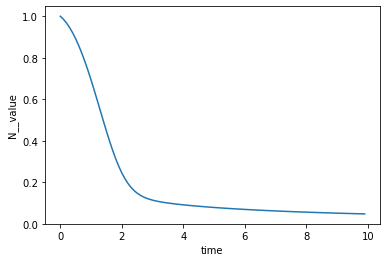

In [32]:
out_a.N__value.plot.line(x='time')

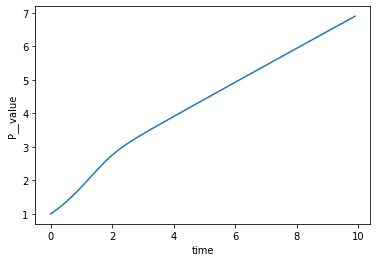

In [33]:
out_a.P__value.plot.line(x='time')

# for later reference, for higher dimensionality:

In [163]:
def initialize_array(gk_class, label, shape, initval = None):
    """This function returns a labeled multi-dimensional m.array of supplied base gk_class"""
    gk_array = m.Array(gk_class, shape)
    
    it = np.nditer(gk_array, flags=['refs_ok','multi_index'], op_flags=['readwrite'])

    i=0
    while not it.finished:
        gk_array[it.multi_index].__dict__['NAME'] = f"{label}_{str(i)}"
        
        if initval != None:
            gk_array[it.multi_index].VALUE = initval
            
        i += 1
        #print(it.value)
        it.iternext()
        
    return gk_array

In [90]:
x_array = initialize_array(m.SV, 'Nutrient', (3,3,3), initval=0)

# once custom simulation stages are possible with xsimlab:
as referenced here: https://github.com/benbovy/xarray-simlab/issues/52
       


In [ ]:
@xs.process
class GekkoExplicitSolve(Solver):
    """NOT WORKING YET,
    this needs two initialize stages, which xsimlab as of yet does not provide
    
    the usefulness would be, seeing progr"""
    
    def initialize(self):
        print('initialize solver')
        self.solver_type = 'step'
        
        # ASSIGN MODEL SOLVING TIME HERE:
        self.i = 1
        
        # add solver options
        self.m.options.REDUCE = 3  # handles reduction of larger models, have not benchmarked it yet
        self.m.options.NODES = 3  # improves solution accuracy
        self.m.options.IMODE = 4  # sequential dynamic solver
        
        #to measure solve time
        self.solve_start = tm.time()
        
    def run_step(self):
        print('solver step')
        self.m.time = [self.i-1,self.i]
        
        self.m.solve(disp=False)
    
        self.i += 1
        
    def finalize_step(self):
        #print(self.m.__dict__)
        print('Running solver now')
        
        solve_end = tm.time()

        print(f"Model was solved in {round(solve_end-self.solve_start,2)} seconds")
        
        #print(self.m.__dict__)